In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import torch

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/xuliang/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/valid.txt')]

In [4]:
num_gpus = torch.cuda.device_count()
num_gpus

2

In [6]:
for gpu_id in range(num_gpus):
    torch.cuda.set_device(gpu_id)
    torch.cuda.empty_cache()
torch.cuda.set_device(0)

In [7]:
path_lbl = path/'labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/xuliang/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/images/0001TP_006750.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/xuliang/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/xuliang/.fastai/data/camvid/labels/0001TP_006750_P.png')]

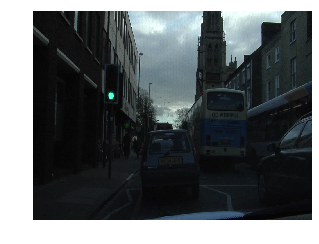

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

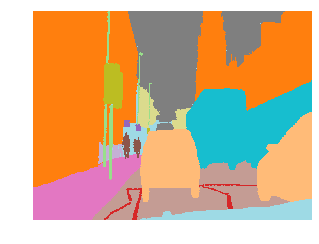

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data


(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=6
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 4426MB of GPU RAM free


In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))


In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [19]:
data.train_ds[0][0].data.mean(dim=[1,2])

tensor([0.2054, 0.2335, 0.2426])

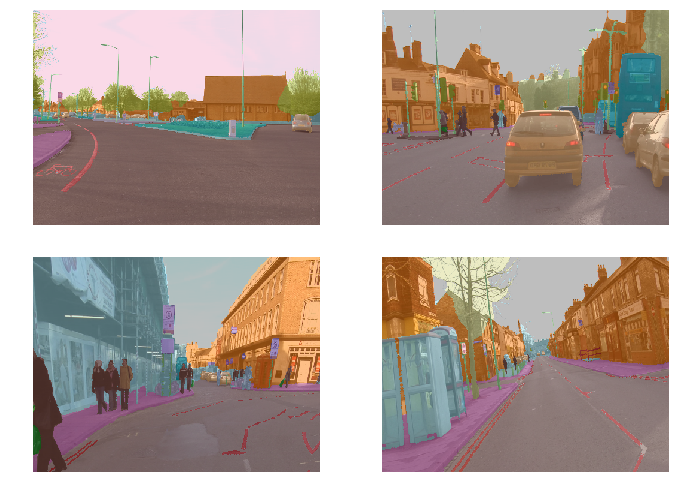

In [20]:
data.show_batch(2, figsize=(10,7))

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()



In [22]:
metrics=acc_camvid

In [23]:
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


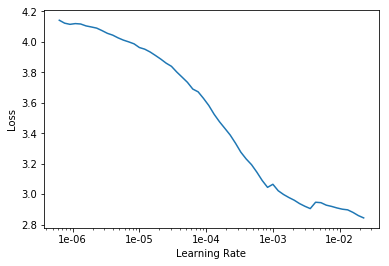

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)